# Consistency check 2

In this file I implement the script to simulate the system with an ancilla Hilbert space in order to simulate thermal states. But furst, to be schure the implementation is consistent, I check that the results are the same as the system witout the ancilla spins.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import quimb as qu
import quimb.tensor as qtn
import quimb.linalg.base_linalg as la
from itertools import product

In [2]:
### PROBLEM PARAMETERS
L = 7         # chain length
omega = 1     # Rabi frequency
V = 0.1       # B-S interaction strength
V_ = 1        # bath interaction strength
beta = 0.1    # inverse temperature for the bath

T = 10        # total time of the simulation
dt = 0.1      # time step for coherece vector time evolution

### USEFUL VARIABLES
dims = [2]*L # overall space of L qbits

I = qu.pauli('I')
X = qu.pauli('Y')
Z = qu.pauli('Z')

### System WITHOUT the Ancilla spins

In [3]:
### BUILDING THE HAMILTONIAN

# fisrt I build the operators tensor identity on ancilla states
nn_op = (I + Z)/2 & (I + Z)/2

print(f'Building Hamiltonian for L={L} \n')
# the hamiltonian
H1 = {i: (omega/2)*X for i in range(L)}
H2 = {None: V_*nn_op, (L-1, 0): V*nn_op, (0, 1): V*nn_op, (1, 2): V*nn_op}

H = qtn.LocalHam1D(L=L, H2=H2, H1=H1, cyclic=True)

### BUILDING THE SPIN CHAIN
# to be consistent I first build the state with the ancilla and then trace out the states

print('Building the spin chain: \n')
binary = '0'*L
print(f'|{binary}>')       
# turning the state into a MPS
psi = qtn.MPS_computational_state(binary, cyclic=True)

psi.show()

print('\ndone')

Building Hamiltonian for L=7 

Building the spin chain: 

|0000000>
 1 1 1 1 1 1 1 1 
+─●─●─●─●─●─●─●─+
  │ │ │ │ │ │ │  

done


In [4]:
### THE SIMULATION

# first I build the observables
observables_tebd = {}
results_ = {}
for ob1, ob2 in product(['I', 'X', 'Y', 'Z'], repeat=2):
    key = ob1 + '1' + ob2 + '2'
    results_[key] = []
    observables_tebd[key] = []

# dropping the identity
observables_tebd.pop('I1I2')
results_.pop('I1I2')
    
# create the object
tebd = qtn.TEBD(psi, H)

# cutoff for truncating after each infenitesimal-time operator application
tebd.split_opts['cutoff'] = 1e-9

t = np.linspace(0, T, 100)
keys = results_.keys()

# I can either set a timestep or a tolerance and the timestep is calculated accordingly
# generate the state at each time in t (same as exact simulation)
#     and target error 1e-3 for whole evolution
for psit in tebd.at_times(t, tol=1e-3):
    for key in keys:
        ob1 = qu.pauli(key[0])
        ob2 = qu.pauli(key[2])
        results_[key].append(psit.H @ psit.gate(ob1&ob2, (0, 1)))

t=10, max-bond=52: 100%|####################################################################################################################################################################################################| 100/100 [00:06<00:00, 15.49it/s]


In [5]:
print(f'Check for the normalization: {tebd.pt.H @ tebd.pt}\n')

Check for the normalization: (0.9999999970024284-5.189704966978442e-16j)



### System WITH the Ancilla spins

In [6]:
### BUILDING THE HAMILTONIAN

# first I build all the parts od the hamiltonian separately
# OCIO: to the factors
O_Rabi = (omega/2)*X & I
N_sys  = 0.5*V*(I + Z)/2 & I
N_bath = 0.5*V_*(I + Z)/2 & I

print(f'Building Hamiltonian for L={L} \n')
# the hamiltonian
H1 = {i: O_Rabi for i in range(L)}
H2 = {None: N_bath&N_bath, (L-1, 0): N_sys&N_sys, (0, 1): N_sys&N_sys, (1, 2): N_sys&N_sys}

H = qtn.LocalHam1D(L=L, H2=H2, H1=H1, cyclic=True)

### BUILDING THE SPIN CHAIN

print('Building the spin chain: \n')
B = np.array([1, 1, 0, 0])/np.sqrt(2)
arrays = [B for i in range(L)]

psi = qtn.MPS_product_state(arrays, cyclic=True)#, site_ind_id='s{}')

psi.show()

print('\ndone')

Building Hamiltonian for L=7 

Building the spin chain: 

 1 1 1 1 1 1 1 1 
+─●─●─●─●─●─●─●─+
  │ │ │ │ │ │ │  

done


In [7]:
### THE SIMULATION

start = time.time()

# first I build the observables
observables_tebd = {}
results = {}
for ob1, ob2 in product(['I', 'X', 'Y', 'Z'], repeat=2):
    key = ob1 + '1' + ob2 + '2'
    results[key] = []
    observables_tebd[key] = []

# dropping the identity
observables_tebd.pop('I1I2')
results.pop('I1I2')
    
# create the object
tebd = qtn.TEBD(psi, H)

# cutoff for truncating after each infinitesimal-time operator application
tebd.split_opts['cutoff'] = 1e-10

t = np.linspace(0, T, 100)
keys = results.keys()

# I can either set a timestep or a tolerance and the timestep is calculated accordingly
# generate the state at each time in t (same as exact simulation)
#     and target error 1e-3 for whole evolution
for psit in tebd.at_times(t, tol=1e-3):
    for key in keys:
        ob1 = qu.pauli(key[0]) & qu.pauli('I')
        ob2 = qu.pauli(key[2]) & qu.pauli('I')
        results[key].append(psit.H @ psit.gate(ob1 & ob2, (0, 1)))
        
end = time.time()
print(f'Time:{int(end - start)}s')

t=10, max-bond=12: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 25.16it/s]

Time:3s


In [8]:
print(f'Check for the normalization: {tebd.pt.H @ tebd.pt}\n')

Check for the normalization: (1.0000000000921119+2.1672429078589907e-16j)



/home/giovanni/anaconda3/envs/NN_Lindblad/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


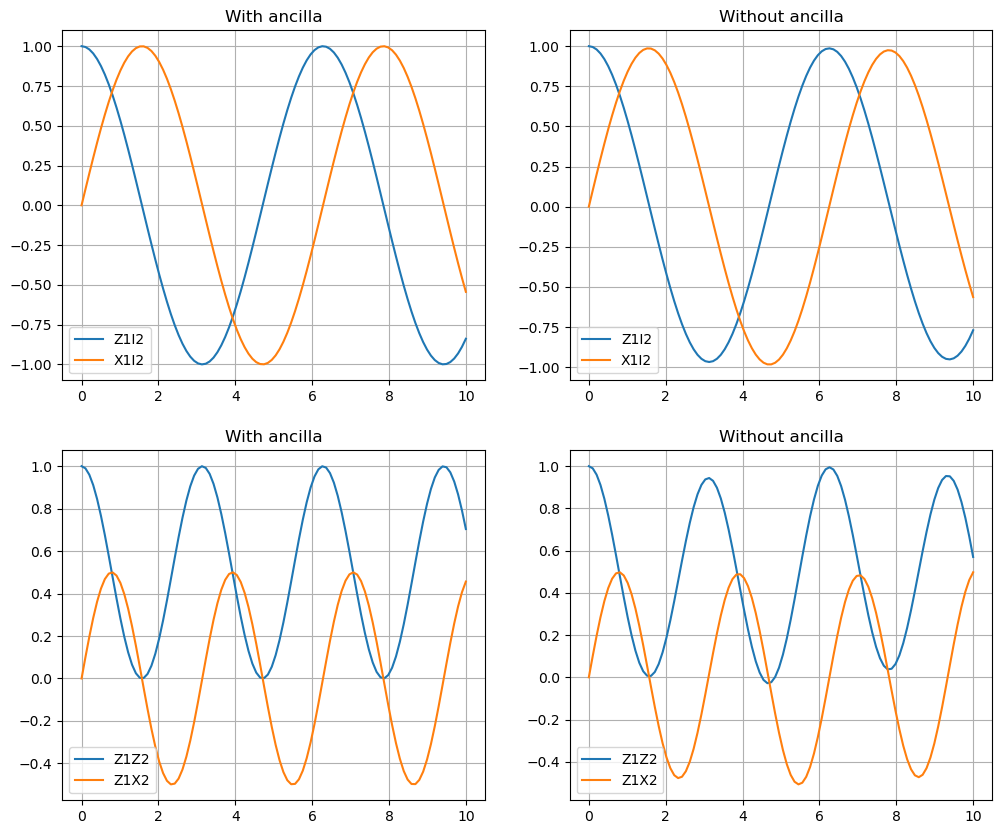

In [9]:
keys = observables_tebd.keys()
keys = ['Z1I2', 'X1I2']

fig, ax = plt.subplots(2, 2, figsize=(12,10))
for key in keys:
    ax[0][0].plot(t, results[key], label=key)
    ax[0][1].plot(t, results_[key], label=key)    
ax[0][0].set_title('With ancilla')
ax[0][1].set_title('Without ancilla')

keys = ['Z1Z2', 'Z1X2']
for key in keys:
    ax[1][0].plot(t, results[key], label=key)
    ax[1][1].plot(t, results_[key], label=key)
ax[1][0].set_title('With ancilla')
ax[1][1].set_title('Without ancilla')

for i in range(2):
    for j in range(2):
        ax[i][j].grid()
        ax[i][j].legend()

#plt.savefig('./pictures/consistency_check_2.pdf')